1. Primero importé los datos al ambiente de trabajo y cargando el archivo A21DF.csv. Después, como necesitaba una variable de salida binaria para aplicar la regresión logística, tomé la columna “Ganancia” y la transformé en una variable categórica. Para hacerlo, generé una nueva columna llamada “target” que vale 1 si la ganancia es mayor a cero, y 0 en caso contrario. De esta forma, convertí el problema en uno de clasificación binaria, donde el modelo predice si habrá ganancia o no.

In [1]:
import pandas as pd
df=pd.read_csv("A21DF.csv")
df["target"] = (df["Ganancia"] > 0).astype(int)

2. Después de crear la variable target, dividí los datos en entrenamiento y prueba con una relación de 80/20. Para garantizar que ambas particiones mantuvieran la misma proporción de clases que en los datos originales, imprimí en consola la distribución de valores de la variable objetivo antes y después de la separación.
En los datos originales, revisé cuántas observaciones correspondían a la clase 0 y cuántas a la clase 1, además de su proporción relativa. Posteriormente, realicé el mismo cálculo para los datos de entrenamiento y para los de prueba, comprobando que las proporciones se mantuvieran prácticamente iguales.
Finalmente, definí las variables independientes (X) y la variable dependiente (y) para cada conjunto, dejando lista la base de entrenamiento para ajustar el modelo y la de prueba para evaluar su desempeño.

In [2]:
print(df.target.value_counts())
print(df.target.value_counts()/df.shape[0])
train=df.sample(frac=.8, random_state=42) #Seleccionamos aleatoriamente el 70% de los datos para entrenamiento
test = df.drop(train.index) #El conjunto de prueba será el 30% restante (los datos que no entraron en train)
x_train=train.drop("target", axis=1) #Definimos las variables independientes (X) para entrenamiento
y_train=train["target"] #Definimos la variable dependiente (y) para entrenamiento
x_test=test.drop("target", axis=1) #Definimos las variables independientes (X) para prueba
y_test=test["target"] #Definimos la variable dependiente (y) para prueba
print(y_train.value_counts())
print(y_train.value_counts()/y_train.shape[0])
print(y_test.value_counts())
print(y_test.value_counts()/y_test.shape[0])

target
1    6548
0      69
Name: count, dtype: int64
target
1    0.989572
0    0.010428
Name: count, dtype: float64
target
1    5239
0      55
Name: count, dtype: int64
target
1    0.989611
0    0.010389
Name: count, dtype: float64
target
1    1309
0      14
Name: count, dtype: int64
target
1    0.989418
0    0.010582
Name: count, dtype: float64


Podemos ver que tanto en train como en test, se sigue una proporción muy similar a la del dataframe. 

3. Con el conjunto de entrenamiento, entrené un modelo de regresión logística utilizando un subconjunto de variables de interés: A131A, Q010A, A119A y A244A. Para evaluar su desempeño de manera, apliqué validación cruzada estratificada con 4 particiones, lo que asegura que en cada fold se mantenga la proporción original de clases.
En cada iteración, el modelo se ajustó con una parte de los datos y se evaluó en la restante, calculando la exactitud (accuracy) como métrica principal. Finalmente, obtuve la exactitud de cada fold y el promedio general, lo que me permitió medir qué tan bien se desempeña el modelo en los datos de entrenamiento de forma consistente y no solo en una partición específica.

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
import numpy as np
X_train_subset = x_train[["A131A", "Q010A", "A119A", "A244A"]]
y_train_subset = y_train
model = LogisticRegression(penalty=None,class_weight="balanced", max_iter=5000)
# Definir validación cruzada estratificada (mantiene proporción de clases)
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Calcular exactitud en cada fold
scores = cross_val_score(model, X_train_subset, y_train_subset, cv=cv, scoring="accuracy")
print("Exactitud en cada fold:", scores)
print("Exactitud promedio:", np.mean(scores))

Exactitud en cada fold: [0.99546828 0.99848943 0.99773243 0.99848828]
Exactitud promedio: 0.9975446036084793


La exactitud es muy alta, de 0.9975.

4. Entrené el modelo de regresión logística con todos los datos de entrenamiento y generé las probabilidades en el conjunto de prueba. Luego probé tres umbrales distintos (0.001, 0.5 y 0.999) y construí las matrices de confusión correspondientes. Con el umbral estándar de 0.5 el modelo mostró un desempeño balanceado; al bajar el umbral aumentó la sensibilidad pero bajó la especificidad, y al subirlo ocurrió lo contrario. Escogí esos valores porque tengo muchas más observaciones de 1 o que de 0, entonces para que de el 1 más fácil sería con el 0.001. 

Intercepto: 1.0779742536325834e-08

Resultados del modelo:

   Variable  Coeficiente  Odds Ratio (exp(coef))
63    A204A     0.006237                1.006257
52    A173A     0.001291                1.001292
8     H020A     0.000809                1.000810
29    Q020A     0.000795                1.000795
9     H020B     0.000481                1.000481
..      ...          ...                     ...
51    A171A    -0.000775                0.999225
3     A221A    -0.000871                0.999129
2     A211A    -0.000886                0.999114
0     A111A    -0.001978                0.998024
28    Q010A    -0.004154                0.995855

[90 rows x 3 columns]


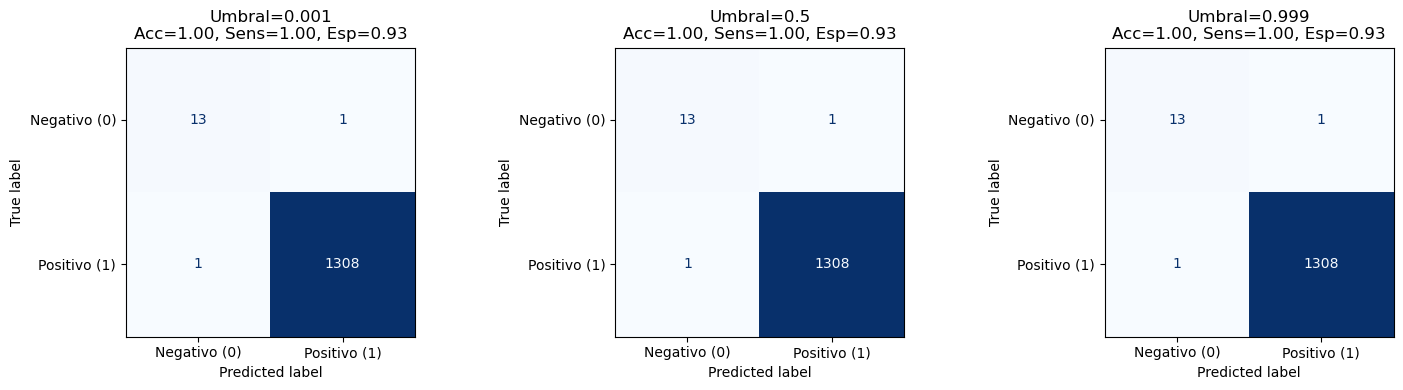

In [11]:
model2 = LogisticRegression(penalty=None,class_weight="balanced", max_iter=5000).fit(x_train,y_train)
pred2 = model2.predict(x_test)
# Intercepto
print("Intercepto:", model2.intercept_[0])

# Coeficientes y variables
coef = model2.coef_[0]
vars_names = x_train.columns  # si tu X es un DataFrame
results = pd.DataFrame({
    "Variable": vars_names,
    "Coeficiente": coef,
    "Odds Ratio (exp(coef))": np.exp(coef)
}).sort_values(by="Coeficiente", ascending=False)

print("\nResultados del modelo:\n")
print(results)
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay as cmd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, ConfusionMatrixDisplay

# Umbrales ajustados
thresholds = [0.001, 0.5, 0.999]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, t in enumerate(thresholds):
    preds = (pred2 >= t).astype(int)
    
    cm = confusion_matrix(y_test, preds)
    
    # Métricas
    acc = accuracy_score(y_test, preds)
    sens = recall_score(y_test, preds, pos_label=1)
    spec = recall_score(y_test, preds, pos_label=0)
    
    # Mostrar matriz con etiquetas
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negativo (0)", "Positivo (1)"])
    disp.plot(ax=axes[i], cmap="Blues", colorbar=False)
    axes[i].set_title(f"Umbral={t}\nAcc={acc:.2f}, Sens={sens:.2f}, Esp={spec:.2f}")

plt.tight_layout()
plt.show()


Como podemos ver, en todos los casos obtuvimos el mismo resultado, debe ser porque hay un valor fuera de lo común que es difícil de clasificar. 

5. Con las probabilidades obtenidas en el punto previo, tracé la curva ROC para evaluar el desempeño global del modelo al variar el umbral de clasificación. La curva muestra la relación entre la tasa de verdaderos positivos (sensibilidad) y la tasa de falsos positivos (1 – especificidad). Además, calculé el valor del AUC, que resume esta capacidad de discriminación: un valor cercano a 1 indica un buen desempeño.

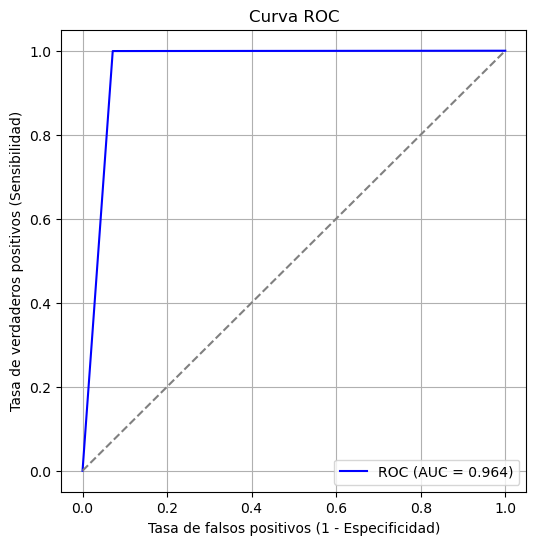

Valor de AUC: 0.964


In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, pred2)
auc = roc_auc_score(y_test, pred2)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC (AUC = {auc:.3f})", color="blue")
plt.plot([0,1], [0,1], "--", color="gray")  # línea aleatoria
plt.xlabel("Tasa de falsos positivos (1 - Especificidad)")
plt.ylabel("Tasa de verdaderos positivos (Sensibilidad)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"Valor de AUC: {auc:.3f}")


6. En este modelo, los coeficientes nos dicen cómo cambia el log-odds del evento cuando cada variable aumenta en una unidad. Si el coeficiente es positivo, el log-odds crece y, por lo tanto, también la probabilidad; si es negativo, el log-odds baja y la probabilidad disminuye.

Por ejemplo, A204A tiene el coeficiente más alto (0.0062), lo que significa que por cada unidad extra en esa variable, el log-odds del evento sube un poco, y el odds ratio (exp(coef)) ≈ 1.0063 indica que las probabilidades aumentan en 0.6%. En el lado contrario, Q010A tiene el coeficiente más negativo (-0.0041), así que reduce el log-odds y su odds ratio (0.9959) implica que las probabilidades bajan en alrededor de 0.4% por unidad.

El resto de las variables también siguen esta lógica, pero sus efectos son mínimos (coeficientes cercanos a cero), así que aunque algunas aumentan y otras reducen el log-odds, el cambio en las probabilidades es muy pequeño.